In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
#import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
#from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from shapely import wkt
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

### Data Preparation and Loading

In [28]:
data_dir = '/Users/saraprice/Documents/NYU/Research/EV_Charging_Stations/Data'

In [29]:
##EV Charging stations data
EV_df = pd.read_csv(os.path.join(data_dir, 'EV_Charging_Stations_NYC_Open_Data.csv'))
#Zip code boundaries (GIS data for plotting)
#zip_boundaries = gpd.read_file(os.path.join(data_dir, 'ZIP_CODE_040114', 'ZIP_CODE_040114.shp'))
#Reference file for NYC zip codes
NYC_zips = pd.read_csv(os.path.join(data_dir, 'NYC_zip_codes.csv'))
#Median income data
income_data = pd.read_csv(os.path.join(data_dir, 'median_income.csv'))
#Poverty data
poverty_data = pd.read_csv(os.path.join(data_dir, 'poverty_census_data_clean.csv'))
#Demo data
demo_data = pd.read_csv(os.path.join(data_dir, 'demo_data_acs_5yr_clean.csv'))
#highway data
highway_data = pd.read_csv(os.path.join(data_dir, 'highways_by_zip.csv'))

In [5]:
NYC_zips = NYC_zips[['zip_code']]
NYC_zips['zip_code'] = NYC_zips['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
NYC_zips.drop_duplicates(inplace = True)
NYC_zips.shape

(240, 1)

In [26]:
NYC_zips['zip_int'] = NYC_zips['zip_code'].astype(int)
NYC_zips[NYC_zips['zip_int']>=11000].shape

(106, 2)

In [6]:
##Clean up EV data
EV_df = EV_df[['Station Name', 'Street Address', 'City', 'ZIP']]
EV_df.rename(columns = {"Station Name": 'station_name',
                        "Street Address":'str_address',
                        "City": 'city',
                        'ZIP': 'zip_code'}, inplace = True)
EV_df['zip_code'] = EV_df['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))

In [7]:
EV_by_zip = EV_df[['station_name', 'zip_code']].groupby(['zip_code']).count().reset_index()\
                    .rename(columns = {'station_name':'station_count'})
EV_by_zip.shape

(104, 2)

In [8]:
#Add in all zip codes in NYC
EV_by_zip = EV_by_zip.merge(NYC_zips, on = ['zip_code'], how = 'right')
print(EV_by_zip.shape)

(240, 2)


In [9]:
EV_by_zip['station_count'].sum()

502.0

In [10]:
#limit to just incomes in NYC
incomes_nyc = income_data[income_data.zip_code.isin(NYC_zips.zip_code)]
incomes_nyc['families_median_income'] = np.where(incomes_nyc['families_median_income']=='250,000+', 250000, 
                                             incomes_nyc['families_median_income'])
incomes_nyc = incomes_nyc[incomes_nyc['families_median_income']!='-']
incomes_nyc['families_median_income'] = incomes_nyc['families_median_income'].astype(int)
incomes_nyc['zip_code'] = incomes_nyc['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
incomes_nyc.shape

(176, 2)

#### Median Income Data

In [11]:
EV_income = pd.merge(EV_by_zip, incomes_nyc, on = 'zip_code', how = 'outer')
EV_income['families_median_income'] = EV_income['families_median_income'] #.fillna(0)
#EV_income['station_count'] = EV_income['station_count'].fillna(0)

#### Poverty Rate

In [12]:
poverty_data['zip_code'] = poverty_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
poverty_nyc = pd.merge(poverty_data, NYC_zips, on = 'zip_code')
EV_poverty = pd.merge(poverty_nyc, EV_by_zip, on = 'zip_code', how = 'outer')
EV_poverty['poverty_rate'] = EV_poverty['poverty_rate'] #.fillna(0)
EV_poverty['non_poverty_rate'] = 1- EV_poverty['poverty_rate']
EV_poverty['station_count'] = EV_poverty['station_count'] #.fillna(0)

#### Racial Demographic Analysis

In [13]:
demo_data['zip_code'] = demo_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
demo_nyc = pd.merge(demo_data, NYC_zips, on = 'zip_code') 

In [14]:
EV_demo = pd.merge(demo_nyc, EV_by_zip, on = 'zip_code', how = 'outer')
EV_demo.drop([col for col in EV_demo.columns if col.find("pop")>0], inplace = True, axis = 1)

#### Highway Data

In [19]:
highway_data.head()

,Unnamed: 0,zip_code,highway_count,highway_bin
0,0,10001,2.0,1.0
1,1,10002,1.0,1.0
2,2,10003,0.0,0.0
3,3,10004,2.0,1.0
4,4,10005,1.0,1.0


In [16]:
highway_data = highway_data[['zip_code', 'highway_count', 'highway_bin']]
highway_data['zip_code'] = highway_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
EV_highway = pd.merge(highway_data, EV_by_zip, on = 'zip_code', how = 'outer')
EV_highway.shape

(240, 4)

#### Combine all data sources 

In [17]:
print(EV_poverty.shape)
print(EV_income.shape)
print(EV_demo.shape)
print(EV_highway.shape)
EV_comb = pd.merge(EV_poverty[['station_count', 'poverty_rate', 'zip_code']], EV_income, 
                   on = ['zip_code', 'station_count'], how = 'left')
print(EV_comb.shape)
EV_comb = pd.merge(EV_comb, EV_demo, on = ['zip_code', 'station_count'])
EV_comb = pd.merge(EV_comb, EV_highway, on = ['zip_code', 'station_count'])
EV_comb['station_present'] = np.where(EV_comb['station_count']>0, 1, 0)
print(EV_comb['zip_code'].drop_duplicates().shape)
print(EV_comb.shape)
EV_comb.drop('zip_code', axis = 1, inplace = True)
EV_comb.fillna(0, inplace = True)
EV_comb.shape

(240, 6)
(240, 3)
(240, 7)
(240, 4)
(240, 4)
(240,)
(240, 12)


(240, 11)

## Analysis of Zip Codes with Stations v. without Stations

### Correlation Coefficients

In [18]:
corr_df = EV_comb.corr()[['station_present', 'station_count']]
corr_df = corr_df[(corr_df.index != 'station_count') & (corr_df.index != 'station_present')]
corr_df.sort_values('station_present', ascending = False)

,station_present,station_count
families_median_income,0.447779,0.582135
white_perc,0.427015,0.432348
highway_bin,0.316402,0.231002
asian_perc,0.243999,0.150984
poverty_rate,0.199501,0.010479
highway_count,0.190108,0.071097
hispanic_perc,0.183389,-0.059648
native_american_perc,0.081155,-0.002074
black_perc,-0.018615,-0.138726


### Descriptive Statistics on Station v. Non-Station Zip Codes

In [19]:
for col in EV_comb.columns:
    if col not in(['station_count', 'station_present', 'highway_bin', 'highway_count']):
        EV_comb[col] = EV_comb[col].replace(0.0, np.nan)
stations = EV_comb[EV_comb['station_present']==1]
no_stations = EV_comb[EV_comb['station_present']!=1]

    

In [44]:
stations[[col for col in stations.columns if col not in(['station_count', 'station_present'])]].describe()

,poverty_rate,families_median_income,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,highway_count,highway_bin
count,98.000000,97.000000,98.000000,98.000000,85.000000,98.000000,98.000000,104.000000,104.000000
mean,0.153929,112000.742268,0.517909,0.167934,0.004018,0.158068,0.250604,1.788462,0.807692
std,0.099989,66109.176627,0.240334,0.208402,0.003224,0.142677,0.186430,1.445939,0.396022
min,0.013193,33282.000000,0.042895,0.004226,0.000294,0.013628,0.032384,0.000000,0.000000
25%,0.092517,64000.000000,0.313184,0.033755,0.001565,0.053723,0.112523,1.000000,1.000000
50%,0.131809,87242.000000,0.563667,0.072635,0.003075,0.104753,0.170535,2.000000,1.000000
75%,0.184809,151028.000000,0.734223,0.200368,0.005965,0.220431,0.336863,2.000000,1.000000
max,0.727723,250000.000000,0.931675,0.889781,0.014794,0.725820,0.768157,6.000000,1.000000


In [38]:
stations.shape

(104, 11)

In [20]:
no_stations.shape

(136, 11)

In [45]:
no_stations[[col for col in no_stations.columns if col not in(['station_count', 'station_present'])]].describe()

,poverty_rate,families_median_income,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,highway_count,highway_bin
count,78.000000,79.000000,80.000000,78.000000,70.000000,79.000000,79.000000,136.000000,136.000000
mean,0.172891,78299.506329,0.390793,0.291237,0.005212,0.139458,0.277865,1.198529,0.500000
std,0.107877,38057.874208,0.262933,0.277587,0.004115,0.140387,0.201799,1.567351,0.501848
min,0.026674,25429.000000,0.024178,0.000221,0.000382,0.001806,0.057071,0.000000,0.000000
25%,0.087053,51657.500000,0.155389,0.049660,0.002103,0.029641,0.124033,0.000000,0.000000
50%,0.137795,75471.000000,0.370060,0.220520,0.003943,0.072519,0.199376,0.500000,0.500000
75%,0.234096,94008.000000,0.578861,0.460528,0.007785,0.235622,0.385670,2.000000,1.000000
max,0.479023,250000.000000,1.000000,0.928471,0.020044,0.475832,0.764944,8.000000,1.000000


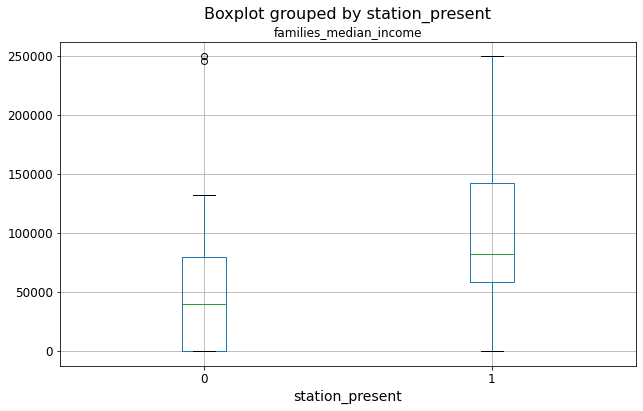

In [22]:
EV_comb.boxplot('families_median_income', by = 'station_present', figsize = (10, 6))

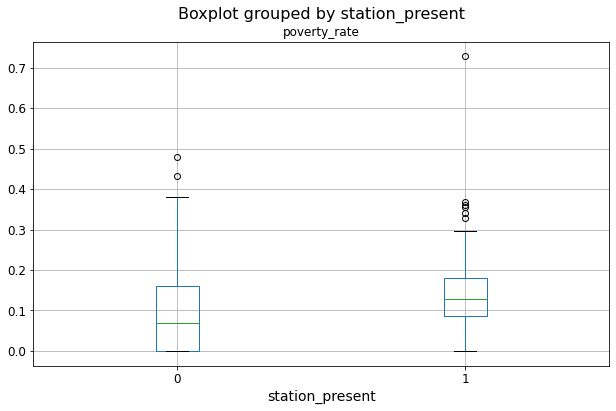

In [23]:
EV_comb.boxplot('poverty_rate', by = 'station_present', figsize = (10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff89e269f40>,
      dtype=object)

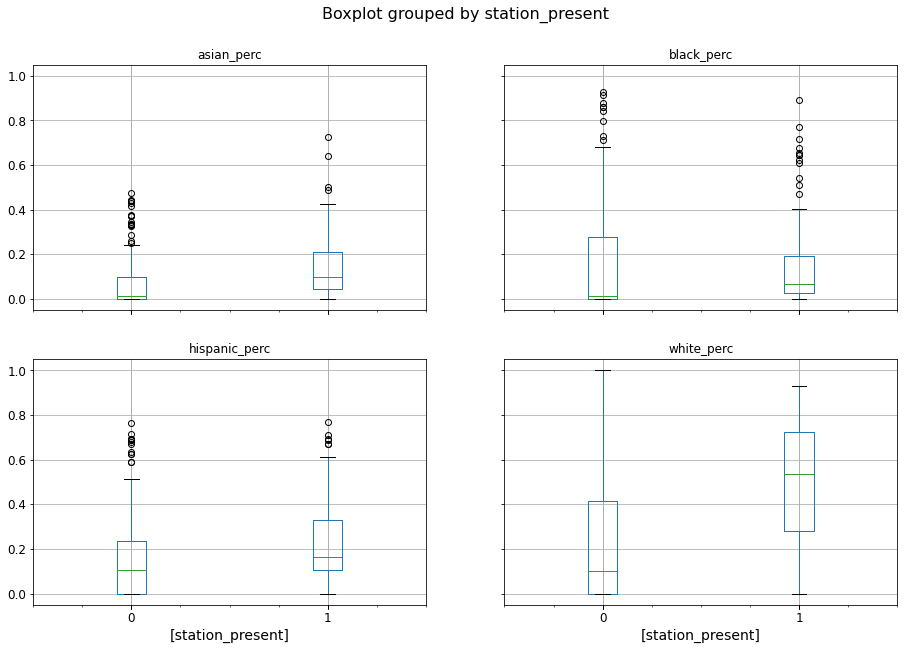

In [24]:
EV_comb[['station_present', 'white_perc', 'black_perc', 'asian_perc', 'hispanic_perc']].boxplot( by = 'station_present', figsize = (15, 10))

### Statistical Analysis between zipcodes with and without EV Charging Stations

In [31]:
no_stations

,station_count,poverty_rate,families_median_income,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,highway_count,highway_bin,station_present
5,0.0,0.033635,245764.0,0.734799,0.032018,0.000000,0.160414,0.108344,3.0,1.0,0
7,0.0,0.235425,71135.0,0.616163,0.086237,0.001201,0.142161,0.237884,1.0,1.0,0
17,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0
28,0.0,0.219729,54699.0,0.314268,0.280250,0.004565,0.041755,0.512033,1.0,1.0,0
34,0.0,0.251636,51536.0,0.101798,0.712198,0.003323,0.027905,0.209755,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0
236,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0
237,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0
238,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1.0,0


In [35]:
stations['highway_bin'].unique()

array([1., 0.])

In [36]:
stations = stations.fillna(0)
no_stations = no_stations.fillna(0)
ttest_cols = [i for i in EV_comb.columns if i not in (['station_count', 'station_present'])]
t_stats = {}
p_vals = {}
for col in ttest_cols:
    if col != 'highway_bin':
        t_stats[col], p_vals[col] = stats.ttest_ind(stations[stations[col]!=0][col], \
                                                no_stations[no_stations[col]!=0][col])
    else:
        t_stats[col], p_vals[col] = stats.ttest_ind(stations[col], no_stations[col])
    
    print(f"Statistical significance for: {col}")
    print("T-statistic: {}".format(t_stats[col]))
    print("P-value: {}".format(p_vals[col]))
    print("--------------------------------")

Statistical significance for: poverty_rate
T-statistic: -1.2067718028957324
P-value: 0.2291581117631306
--------------------------------
Statistical significance for: families_median_income
T-statistic: 4.01965756901483
P-value: 8.667254767157703e-05
--------------------------------
Statistical significance for: white_perc
T-statistic: 3.364689925114979
P-value: 0.0009406151652702986
--------------------------------
Statistical significance for: black_perc
T-statistic: -3.3651369623647005
P-value: 0.0009413133284921931
--------------------------------
Statistical significance for: native_american_perc
T-statistic: -2.025225205073821
P-value: 0.04458289679874779
--------------------------------
Statistical significance for: asian_perc
T-statistic: 0.8688145788179996
P-value: 0.3861385269243488
--------------------------------
Statistical significance for: hispanic_perc
T-statistic: -0.9320805417555871
P-value: 0.3525790342711467
--------------------------------
Statistical significance 

## Deeper Dive Analysis on Zip Codes with Stations Present

### Correlation Coefficients on Just Station Present Data

In [28]:
statitons_corr = stations.corr()[['station_count']]
statitons_corr = statitons_corr[(statitons_corr.index != 'station_count') & (statitons_corr.index != 'station_present')]
statitons_corr.sort_values('station_count', ascending = False)

,station_count
families_median_income,0.572557
white_perc,0.408279
asian_perc,0.027347
native_american_perc,-0.096214
poverty_rate,-0.202755
black_perc,-0.267552
hispanic_perc,-0.314737
non_white_perc,-0.408279


### Conditional Analysis
Below are scatterplots of racial percentage per zipcode for zipcodes with stations present versus the number of stations present. The plots are also color coded based on whether or not median household income is above the median for the full city of New York in a given zip code. 

In [49]:
med_inc_thres = 64000
labels_dict = {'white_perc': 'Percentage of Zip Code Population Identifying as White',
              'black_perc': 'Percentage of Zip Code Population Identifying as Black',
              'asian_perc': 'Percentage of Zip Code Population Identifying as Asian',
              'hispanic_perc': 'Percentage of Zip Code Population Identifying as Hispanic',
              }

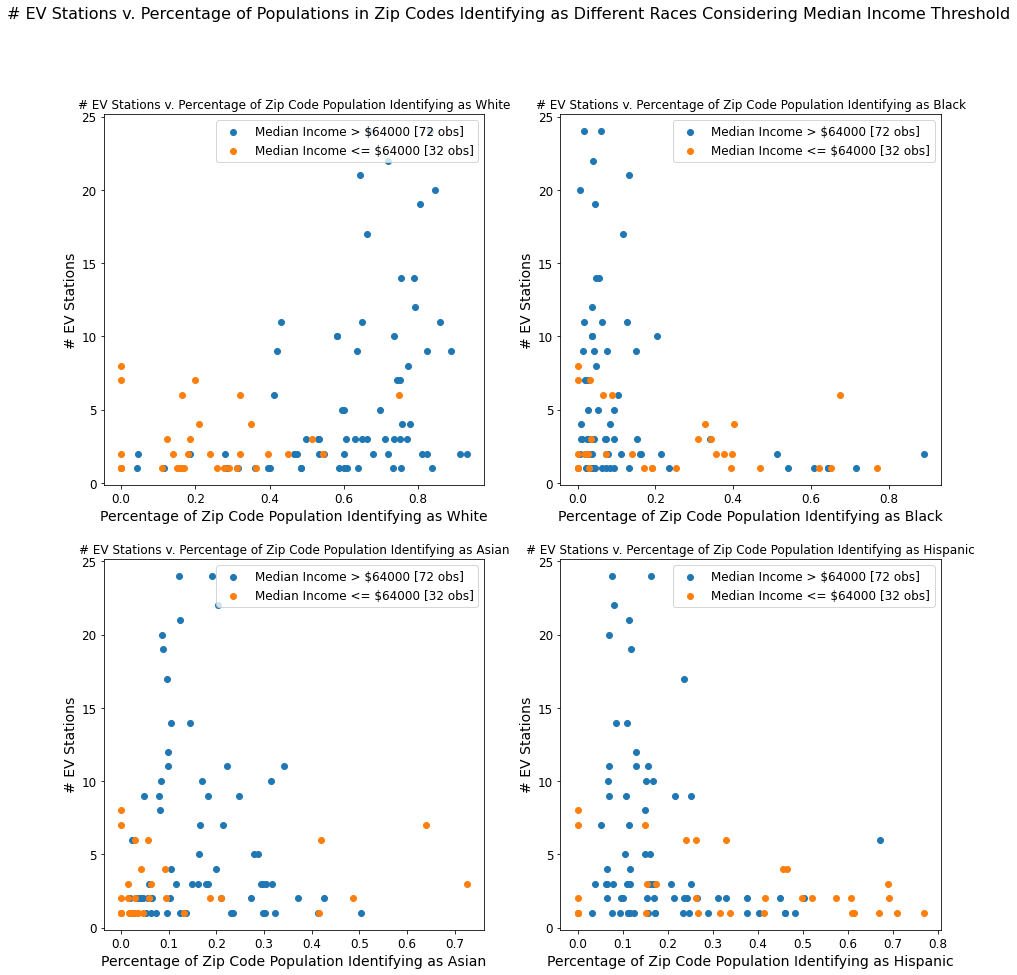

In [30]:
axs = {}
fig, ((axs[0], axs[1]), (axs[2], axs[3])) = plt.subplots(2,2, figsize = (15,15))
fig.suptitle("# EV Stations v. Percentage of Populations in Zip Codes Identifying as Different Races Considering Median Income Threshold")
i = 0
labels_dict
for col in labels_dict.keys():
    over_inc = stations[stations['families_median_income']> med_inc_thres]
    under_inc = stations[stations['families_median_income']<= med_inc_thres]
    axs[i].scatter(over_inc[col], over_inc['station_count'],
            label = "Median Income > ${} [{} obs]".format(med_inc_thres, len(over_inc)))
    axs[i].scatter(under_inc[col], under_inc['station_count'],
            label = "Median Income <= ${} [{} obs]".format(med_inc_thres, len(under_inc)))
    axs[i].set(ylabel = '# EV Stations', xlabel = labels_dict[col], \
           title = "# EV Stations v. {}".format(labels_dict[col]))
    axs[i].legend(loc='upper right')
    
    i+=1

### Combined Minority Groups

In [47]:
axs = {}
stations['non_white_perc'] = 1- stations['white_perc']

plt.figure(figsize = (,6))
over_inc = stations[stations['families_median_income']> med_inc_thres]
under_inc = stations[stations['families_median_income']<= med_inc_thres]
plt.scatter(over_inc['non_white_perc'], over_inc['station_count'],
            label = "Median Income > ${} [{} obs]".format(med_inc_thres, len(over_inc)))
plt.scatter(under_inc['non_white_perc'], under_inc['station_count'],
            label = "Median Income <= ${} [{} obs]".format(med_inc_thres, len(under_inc)))
plt.ylabel('# EV Stations')
plt.xlabel('Non-white Percentage of Zip Code Population'), \
plt.title("# EV Stations v. Non-white Percentage of Zip Code Population")
plt.legend(loc='upper right')
 


SyntaxError: invalid syntax (<ipython-input-47-581f90fe344d>, line 4)

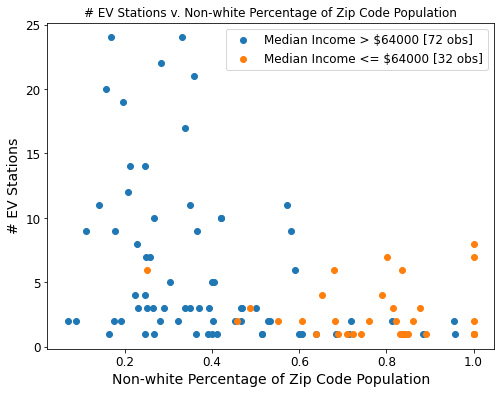

In [32]:
axs = {}
stations['non_white_perc'] = 1- stations['white_perc']

plt.figure(figsize = (8,6))
over_inc = stations[stations['families_median_income']> med_inc_thres]
under_inc = stations[stations['families_median_income']<= med_inc_thres]
plt.scatter(over_inc['non_white_perc'], over_inc['station_count'],
            label = "Median Income > ${} [{} obs]".format(med_inc_thres, len(over_inc)))
plt.scatter(under_inc['non_white_perc'], under_inc['station_count'],
            label = "Median Income <= ${} [{} obs]".format(med_inc_thres, len(under_inc)))
plt.ylabel('# EV Stations')
plt.xlabel('Non-white Percentage of Zip Code Population'), \
plt.title("# EV Stations v. Non-white Percentage of Zip Code Population")
plt.legend(loc='upper right')
 


### Conditional Analysis with highway present

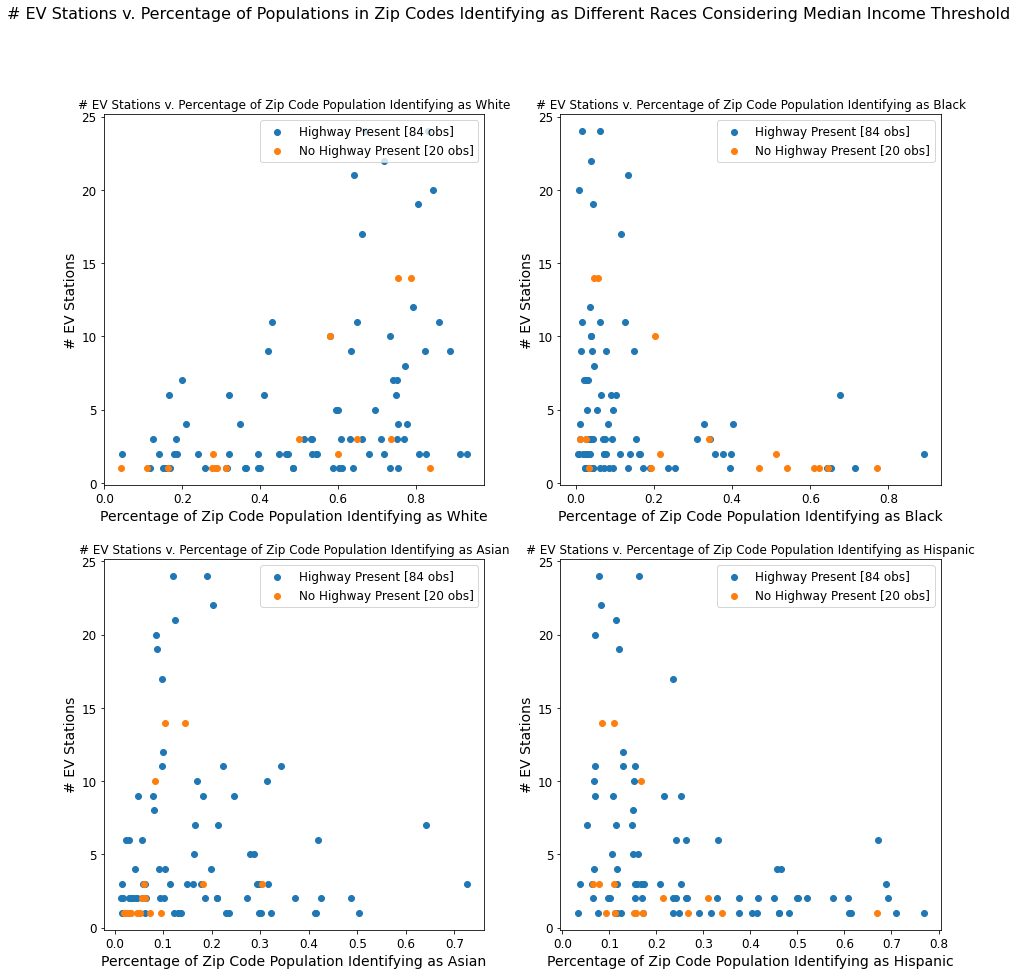

In [50]:
axs = {}
fig, ((axs[0], axs[1]), (axs[2], axs[3])) = plt.subplots(2,2, figsize = (15,15))
fig.suptitle("# EV Stations v. Percentage of Populations in Zip Codes Identifying as Different Races Considering Median Income Threshold")
i = 0
labels_dict
for col in labels_dict.keys():
    highway = stations[stations['highway_bin']==1]
    no_highway = stations[stations['highway_bin']==0]
    axs[i].scatter(highway[col], highway['station_count'],
            label = "Highway Present [{} obs]".format(len(highway)))
    axs[i].scatter(no_highway[col], no_highway['station_count'],
            label = "No Highway Present [{} obs]".format(len(no_highway)))
    axs[i].set(ylabel = '# EV Stations', xlabel = labels_dict[col], \
           title = "# EV Stations v. {}".format(labels_dict[col]))
    axs[i].legend(loc='upper right')
    
    i+=1

### Logistic Regression

In [53]:
X = EV_comb.drop(['station_count', 'station_present'], axis = 1)
X = X.iloc[np.ravel(np.where(np.sum(np.array(X), axis = 1)>0)),:]
print(X.shape)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
Y = np.array(EV_comb[['station_present']].iloc[np.ravel(np.where(np.sum(np.array(X), axis = 1)>0)),:])
Y.shape

(130, 9)


(130, 1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25)

In [74]:
LR = LogisticRegression().fit(X_train, y_train) 

lr_score = LR.predict_proba(X_test)
lr_preds = LR.predict(X_test)
LR.score(X_test, y_test)

0.696969696969697

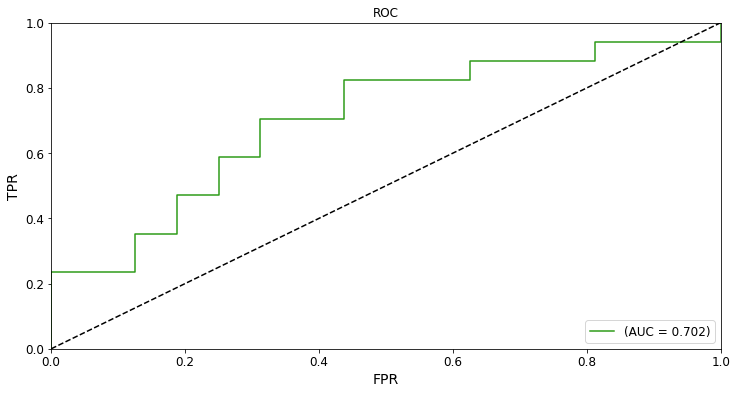

In [75]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (12,6))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), lr_score[:,1])
roc_auc = auc(fpr, tpr)

#chooses a random color for plotting
c = (np.random.rand(), np.random.rand(), np.random.rand())

#plot current model ROC curve
plt.plot(fpr, tpr, color = c, label ='(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()